In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

__file__ = '/content/drive/MyDrive/aiffelthon/data'


Mounted at /content/drive


## Environment

In [2]:
from string import ascii_uppercase
#from draw_utils import *
#from pyglet.gl import *
import numpy as np
import pandas as pd
import os
import random
from datetime import datetime
import pytz
import matplotlib.pyplot as plt

#__file__ = '/home/ogangza/heung_path_finding/path-finding-rl/data' ## GCP용
local_path = os.path.abspath(os.path.join(os.path.dirname(__file__)))

class Simulator:
    def __init__(self):
        # 데이터 로드, 그리드월드 크기 지정
        self.files = pd.read_csv(os.path.join(local_path, "./data/factory_order_train.csv"))
        self.height = 10 # 그리드 높이
        self.width = 9 # 그리드 너비
        self.inds = list(ascii_uppercase)[:17] #inds : A ~ Q alphabet list
        self.x = None
        self.y = None

    def set_box(self): # env.target에 이번에 방문해야 할 좌표 저장
        box_data = pd.read_csv(os.path.join(local_path, "./data/box.csv"))
        order_item = list(set(self.inds) & set(self.items))  # 에피소드에 해당하는 items는 reset 메서드에서 결정
        order_csv = box_data[box_data['item'].isin(order_item)]
        for order_box in order_csv.itertuples(index = True, name ='Pandas'):
            self.target.append([getattr(order_box, "row"), getattr(order_box, "col")] )
        ###############################################################
        self.target.append([9,4]) # 최종 목적지 (출발점) 추가
        ###############################################################
        
    def reset(self, epi): #  에피소드 시작에서 사용... 목표물 리스트 만들기
        self.epi = epi  # 에피소드 번호 받기
        # 에피소드 번호에 해당하는 목표물 리스트 만들기 → 결과 self.target에 들어 옴
        self.target = []
        self.items = list(self.files.iloc[self.epi])[0]  # 해당 에피소드의 items를 가져 옴. 예, [ 'H', 'L', 'M']
        self.set_box()  # 에이전트가 이번에 방문해야 할 좌표들 저장. 예, [ [0,3], [0,7], [0,8], [9,4] ]
        # 목표물 리스트에서 첫 번째 목표물 받아오기
        #(end_x, end_y) = self.target[0] # 에피소드의 첫 번째 도착점
        #print('self.target[0]', end_x, end_y)
        #return (end_x, end_y)

    def step(self, action):
        if action == 0:     # up
            self.move_up()
        elif action == 1:   # down
            self.move_down()
        elif action == 2:   # left
            self.move_left()
        else: # action == 3:# right
            self.move_right()

        reward = -1
        done = self.is_done()
        if done:
            reward = 100
        return (self.x, self.y), reward, done

    def move_up(self):  # action == 0:
        if self.x <= 0:
            pass
        elif self.x in [6,5,4,3,2] and self.y in [0,8]:
            pass
        elif self.x in [7,6,5,4] and self.y in [2,4,6]:
            pass
        else:
            self.x -= 1

    def move_down(self): # action == 1:
        if self.x >= 9:
            pass
        elif self.x == 8 and self.y in [0,1,2,3,5,6,7,8]:
            pass
        elif self.x in [2,3,4,5] and self.y in [2,4,6]:
            pass
        elif self.x in [1,2,3,4,5] and self.y in [0,8]:
            pass
        else:
            self.x += 1
        
    def move_left(self): # left elif action == 2:
        #print('현위치', self.x,self.y)
        if self.y <= 0:
            pass
        elif self.y == 1 and self.x in [2,3,4,5]:
            pass
        elif self.y in [3,5,7] and self.x in [3,4,5,6]:
            pass
        elif self.x == 9:
            pass
        else:
            self.y -= 1

    def move_right(self): # right else: action == 3:
        if self.y >= 8:
            pass
        elif self.y == 7 and self.x in [2,3,4,5]:
            pass
        elif self.y in [1,3,5] and self.x in [3,4,5,6]:
            pass
        elif self.x == 9:
            pass
        else:
            self.y += 1

    def is_done(self):
        if self.x == self.end_x and self.y == self.end_y:
            return True
        else:
            return False

## Agent

In [3]:
class QAgent():
    def __init__(self):
        self.height = env.height # 그리드 높이
        self.width = env.width # 그리드 너비
        self.q_table = np.zeros((self.height, self.width, 4)) # Q 테이블을 0으로 초기화
        self.eps = 0.9
        self.alpha = 0.1

    def select_action(self, s):  # eps-greedy로 액션을 선택해준다
        x, y = s
        coin = random.random()
        if coin < self.eps:
            action = random.randint(0,3)
        else:
            action_val = self.q_table[x,y,:]
            action = np.argmax(action_val)
        return action

    def update_table(self, transition):
        s, a, r, s_prime = transition
        x,y = s
        next_x, next_y = s_prime
        # Q러닝 업데이트 식을 이용 
        self.q_table[x,y,a] = self.q_table[x,y,a] + self.alpha * (r + np.amax(self.q_table[next_x,next_y,:]) - self.q_table[x,y,a])

    def anneal_eps(self):
        self.eps -= 0.01  # Q러닝에선 epsilon 이 좀더 천천히 줄어 들도록 함
        self.eps = max(self.eps, 0.1) 

    def show_table(self):
        q_lst = self.q_table.tolist()
        data = np.zeros((self.height, self.width))
        for row_idx in range(len(q_lst)):
            row = q_lst[row_idx]
            for col_idx in range(len(row)):
                col = row[col_idx]
                action = np.argmax(col)
                data[row_idx, col_idx] = action
        return data

    def show_table_final(self):
        q_lst = self.q_table.tolist()
        data = np.zeros((self.height, self.width))
        data_direction = np.zeros((self.height, self.width))
        for row_idx in range(len(q_lst)):
            row = q_lst[row_idx]
            for col_idx in range(len(row)):
                col = row[col_idx]
                action = np.argmax(col)
                data[row_idx, col_idx] = action
        print(data)
        #상, 하, 좌, 우 = 0, 1, 2, 3
        data_direction = np.where(data == 2., '←', data)
        data_direction = np.where(data == 0., '↑', data_direction)
        data_direction = np.where(data == 3., '→', data_direction)
        data_direction = np.where(data == 1., '↓', data_direction)
        data_direction[9,4] = 'S'
        #data_direction[9,4] = 'G'
        # 맨 아래 줄
        for i in range(4):
            data_direction[9,i] = '■'
        for i in range(5,9):
            data_direction[9,i] = '■'
        # 맨 윗 줄
        upper_line = 'ⓔⓕⓖⓗⓘⓙⓚⓛⓜ'
        for i in range(9):
            data_direction[0,i] = upper_line[i]
        # 왼쪽, 오른쪽 줄
        left_line = 'ⓓⓒⓑⓐ'
        right_line = 'ⓝⓞⓟⓠ'
        for i in range(2,6):
            data_direction[i,0] = left_line[i-2]
            data_direction[i,8] = right_line[i-2]
        # 중간 장애물
        for i in range(3,7):
            data_direction[i,2] = '■'
            data_direction[i,4] = '■'
            data_direction[i,6] = '■'
        print(data_direction)
        return

### Q Table에서 최적 경로 읽는 함수

In [4]:
def optimal_path(start, end, data):
    x, y = start
    end_x, end_y = end
    local_path = [ [x, y] ]
    action = int(data[x, y])
    while [x, y] != [end_x, end_y]:
        if action == 0:
            x -= 1
        elif action == 1:
            x += 1
        elif action == 2:
            y -= 1
        elif action == 3:
            y += 1
        local_path.append([x, y])
        action = int(data[x, y])
    return local_path


### Q-Learning: 출발점과 도착점이 주어졌을 때 최적 경로 찾는 함수

In [5]:
def path_finder(start_point, end_point):

    # start_point = [x, y], end_point = [x, y]: 리스트 또는 튜플
    # Q Table 초기화... 모두 0값으로
    agent.q_table = np.zeros((env.height, env.width, 4)) # Q Table 초기화
    # 아래 for loop 단축에 필요한 초기화
    cur_path = []
    cnt = 0
# >>>>>>>>>>>>>>>>>>>>> 최적 경로 찾기 시작 <<<<<<<<<<<<<<<<<<<<<
    for iter in range(500000): 
        # 출발지, 목적지 좌표 지정
        env.x, env.y = start_point                # 출발지 좌표
        env.end_x, env.end_y = end_point          # 목적지 좌표
        # 목적지 도착 flag 및 출발지 초기화
        done = False
        s = start_point
        while not done: # 한 칸씩 이동. 목적지 도착하면 종료
            a = agent.select_action(s) # e-greedy로 액션 선택
            s_prime, r, done = env.step(a)
            agent.update_table((s, a, r, s_prime))
            s = s_prime
        agent.anneal_eps()  # epsilon 조정 후 경로 (최적해) 찾기 반복
        # for loop 단축을 위한 조건 지정: iter > threshold(= 1500) 일 때, 경로가 10번 연속 같으면 for loop 종료
        # threshold값을 너무 작게 잡으면 수렴이 하지 않은 상태가 되며 이 경우 에러 발생 가능 (optimal_path 함수에서)
        if iter > 2000:
            data = agent.show_table()
            new_path = optimal_path(start_point, end_point, data)
            if new_path == cur_path:
                cnt += 1
                if cnt >= 10:
                    print('path_finder: 반복 횟수', iter,'에서 10번 연속 같음')
                    iter = 0
                    break
            else:
                cnt = 0
                cur_path = new_path
# >>>>>>>>>>>>>>>>>>>>> 최적 경로 찾기 완료 <<<<<<<<<<<<<<<<<<<<<
    data = agent.show_table()
    #print(data)
    local_path = optimal_path(start_point, end_point, data)
    #print(local_path)
    agent.show_table_final()
    return local_path


### Q-Learning Main

In [7]:
tz = pytz.timezone('Asia/Seoul')
env = Simulator()
agent = QAgent() # Q Table 초기화

# 에피소드 번호 지정
epi = 1
# 출발점 만들기
start = (9,4) # 최초 출발점 좌표 고정
# 도착점 리스트 만들기
env.x, env.y = start # 출발점을 현 위치로 지정
env.reset(epi) # 에피소드 번호에 해당하는 목표물 리스트 만들기 → 결과 env.target(리스트)에 들어 옴
print('목적지 문자:', list(env.files.iloc[1])[0])
print('목적지 좌표:', env.target)

final_path = []

#목적지 좌표: [[0, 3], [0, 7], [0, 8], [9, 4]]
# >>>>>>>>>>>>>>>>>>>>> 첫 번째 도착지 시작 <<<<<<<<<<<<<<<<<<<<<

end_point = env.target[0]

for i in range(len(env.target)):
    if i == 0:
        start_point = [9, 4]
    else:
        start_point = env.target[i-1]

    end_point = env.target[i]
    local_path = path_finder(start_point, end_point)
    print(local_path)
    final_path.append(local_path)
    
print(final_path)



TypeError: ignored

### Grid World

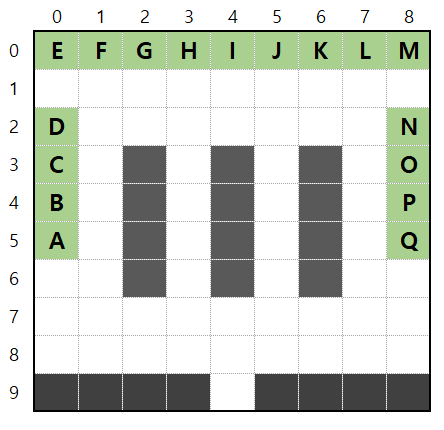